 **AUDIO SENTIMENT ANALYSIS**

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf
import pandas as pd
from IPython.display import Audio
import joblib

In [39]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [40]:
!cp kaggle.json ~/.kaggle/

In [41]:
!chmod 600 ~/.kaggle/kaggle.json

In [42]:
!kaggle datasets download imsparsh/audio-speech-sentiment

Dataset URL: https://www.kaggle.com/datasets/imsparsh/audio-speech-sentiment
License(s): CC0-1.0
audio-speech-sentiment.zip: Skipping, found more recently modified local copy (use --force to force download)


In [43]:
!unzip audio-speech-sentiment.zip

Archive:  audio-speech-sentiment.zip
replace TEST/112.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: TEST/112.wav            
  inflating: TEST/113.wav            
  inflating: TEST/115.wav            
  inflating: TEST/119.wav            
  inflating: TEST/123.wav            
  inflating: TEST/124.wav            
  inflating: TEST/125.wav            
  inflating: TEST/128.wav            
  inflating: TEST/13.wav             
  inflating: TEST/130.wav            
  inflating: TEST/131.wav            
  inflating: TEST/132.wav            
  inflating: TEST/134.wav            
  inflating: TEST/135.wav            
  inflating: TEST/136.wav            
  inflating: TEST/138.wav            
  inflating: TEST/141.wav            
  inflating: TEST/142.wav            
  inflating: TEST/143.wav            
  inflating: TEST/146.wav            
  inflating: TEST/15.wav             
  inflating: TEST/152.wav            
  inflating: TEST/157.wav            
  inflating: TEST/158.wav  

In [44]:
metadata = pd.read_csv('TRAIN.csv')
audio_paths = metadata['Filename'].values
labels = metadata['Class'].values

In [45]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [46]:
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    audio_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

In [47]:
# Feature Extraction Parameters
SAMPLE_RATE = 22050
DURATION = 3  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [48]:
def extract_features(file_path):
    # Load and preprocess audio
    waveform, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Pad or truncate
    if len(waveform) < SAMPLES_PER_TRACK:
        waveform = np.pad(waveform, (0, max(0, SAMPLES_PER_TRACK - len(waveform))), mode='constant')
    else:
        waveform = waveform[:SAMPLES_PER_TRACK]

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(
        y=waveform,
        sr=sr,
        n_mfcc=40,
        n_fft=2048,
        hop_length=512
    )
    return mfccs.T  # Transpose to (time_steps, features)

In [49]:
def process_files(file_paths):
    features = []
    for path in file_paths:
        full_path = os.path.join('TRAIN', path)
        mfcc = extract_features(full_path)
        features.append(mfcc)
    return np.array(features)

In [50]:
X_train = process_files(X_train_paths)
X_test = process_files(X_test_paths)

In [51]:
scaler = StandardScaler()

In [52]:
# Reshape for scaling
train_samples, timesteps, features = X_train.shape
X_train_flat = X_train.reshape(-1, features)
scaler.fit(X_train_flat)

StandardScaler()

In [53]:
# Scale both train and test
X_train_scaled = scaler.transform(X_train_flat).reshape(train_samples, timesteps, features)
test_samples = X_test.shape[0]
X_test_flat = X_test.reshape(-1, features)
X_test_scaled = scaler.transform(X_test_flat).reshape(test_samples, timesteps, features)

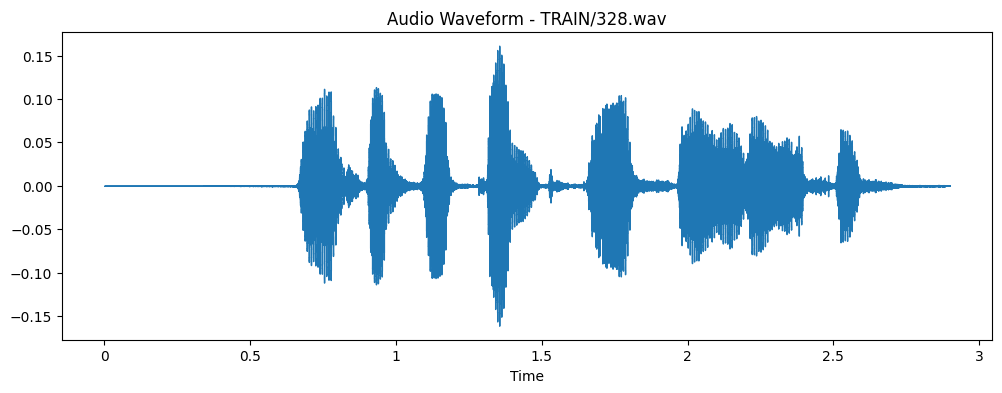

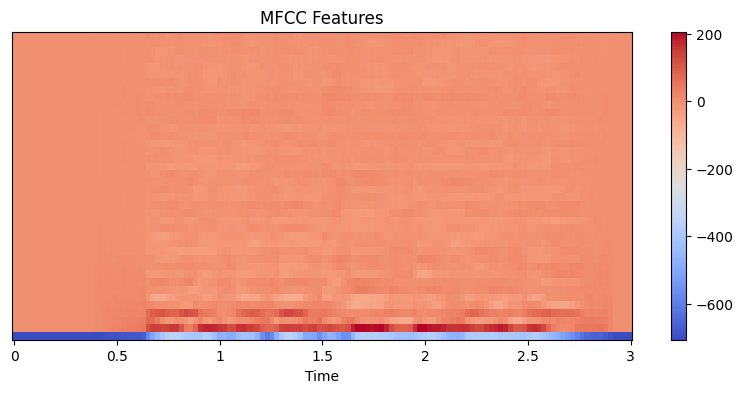

In [54]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def plot_eda(sample_index):
    file_path = os.path.join("TRAIN", X_train_paths[sample_index])  # Adjust directory

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File {file_path} not found!")
        return

    # Load audio
    waveform, _ = librosa.load(file_path, sr=SAMPLE_RATE)

    # Plot waveform
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
    plt.title(f'Audio Waveform - {file_path}')
    plt.show()

    # Check MFCC shape before plotting
    if len(X_train) > sample_index:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(X_train[sample_index].T,
                                 sr=SAMPLE_RATE,
                                 hop_length=512,
                                 x_axis='time')
        plt.colorbar()
        plt.title('MFCC Features')
        plt.show()
    else:
        print(f"Error: Index {sample_index} is out of range for MFCC data.")

    # Play audio
    display(Audio(file_path))

plot_eda(0)


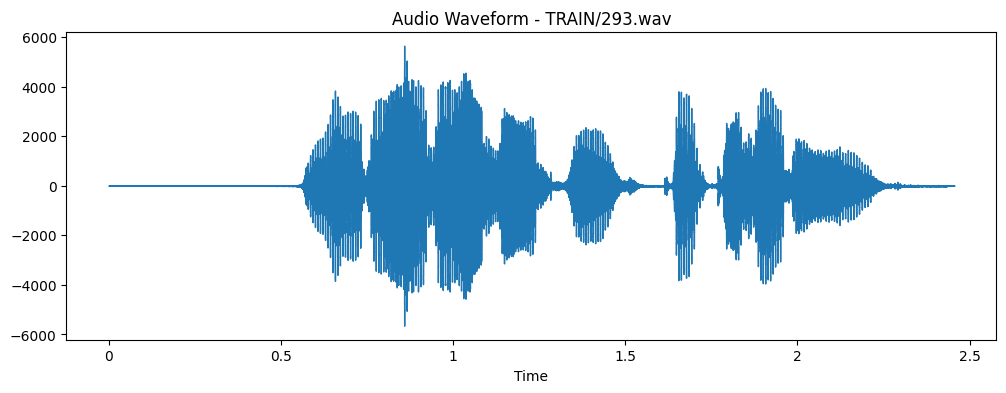

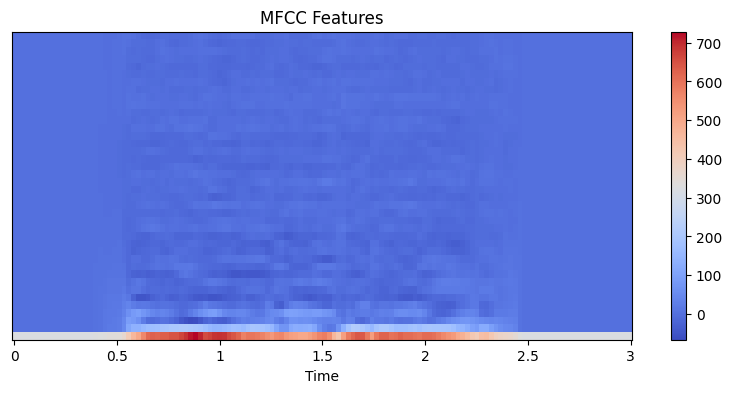

In [55]:
plot_eda(1)

In [56]:
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6113 - loss: 1.0542 - val_accuracy: 0.7250 - val_loss: 0.5788
Epoch 2/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9200 - loss: 0.1644 - val_accuracy: 0.7750 - val_loss: 0.5163
Epoch 3/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 0.9000 - val_loss: 0.4596
Epoch 4/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9000 - val_loss: 0.4544
Epoch 5/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9000 - val_loss: 0.4092
Epoch 6/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9923 - loss: 0.0126 - val_accuracy: 0.9250 - val_loss: 0.3149
Epoch 7/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9966 - loss: 0.0107 - val_accuracy: 0.9250 - val_loss: 0.2974
Epoch 8/60
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9250 - val_loss: 0.3360

In [58]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9867 - loss: 0.0489

Test accuracy: 0.9800


In [59]:
# Saving models
model.save('audio_sentiment_cnn.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

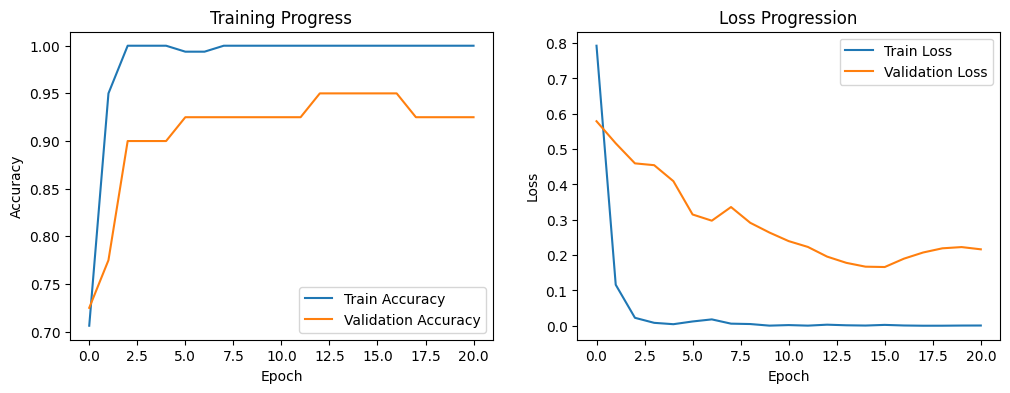

In [60]:
# Training progress visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Progression')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [61]:
def predict_sentiment(audio_path):
    # Load artifacts
    model = tf.keras.models.load_model('audio_sentiment_cnn.h5')
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')

    # Process input
    features = extract_features(audio_path)
    features_scaled = scaler.transform(features.reshape(-1, features.shape[-1]))
    features_scaled = features_scaled.reshape(1, *features.shape)

    # Predict
    proba = model.predict(features_scaled)
    pred = np.argmax(proba)
    return label_encoder.inverse_transform([pred])[0]

In [62]:
model = tf.keras.models.load_model('audio_sentiment_cnn.h5')
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [68]:
from IPython.display import display, Audio

audio_file = "132.wav"
display(Audio(audio_file))  # Playing audio
predicted_sentiment = predict_sentiment(audio_file)
print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Predicted Sentiment: Neutral
